In [1]:
# -*- coding: UTF-8 -*-
from __future__ import unicode_literals, division, print_function, absolute_import
from builtins import range, str, zip
import re
import os
from glob import glob
from copy import deepcopy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.svm import LinearSVC
from gensim.models.word2vec import Word2Vec
from nlputils.features import preprocess_text
from nlputils.simmat import dist2kernel
from nlputils.embedding import proj2d
from nlputils.visualize import basic_viz, get_colors
from word_emb_sim import compute_w2v_K, transform_word2vec_featmat

py.init_notebook_mode()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load data and bootstrap emotion labels

In [2]:
# load posts with partially annotated categories
df = pd.read_csv("data/posts_categories.tsv", sep="\t")
posts = {}
posts_pp = {}
post_categories = {}
post_subcategories = {}
post_likes = {}
post_love = {}
post_haha = {}
post_sad = {}
post_wow = {}
post_angry = {}
# read in all posts and (if available) category
for i in range(len(df)):
    if not pd.isna(df.iloc[i]["link"]) and not pd.isna(df.iloc[i]["post_message"]):
        posts[df.iloc[i]["post_id"]] = df.iloc[i]["post_message"]
        # count reactions
        post_likes[df.iloc[i]["post_id"]] = df.iloc[i]["likes_count_fb"]
        post_love[df.iloc[i]["post_id"]] = df.iloc[i]["rea_LOVE"]
        post_haha[df.iloc[i]["post_id"]] = df.iloc[i]["rea_HAHA"]
        post_sad[df.iloc[i]["post_id"]] = df.iloc[i]["rea_SAD"]
        post_wow[df.iloc[i]["post_id"]] = df.iloc[i]["rea_WOW"]
        post_angry[df.iloc[i]["post_id"]] = df.iloc[i]["rea_ANGRY"]
        # get category (all labeled) and possibly subcategory (some have more than 1!!)
        post_categories[df.iloc[i]["post_id"]] = df.iloc[i]["category_new"]
        if not pd.isna(df.iloc[i]["subcategory"]):
            post_subcategories[df.iloc[i]["post_id"]] = df.iloc[i]["subcategory"].split(", ")
        # for articles we can also extract the headline from the url
        if not df.iloc[i]["link_domain"] == "facebook.com":
            link = df.iloc[i]["link"]
            if df.iloc[i]["link_domain"] == "m.exactag.com":
                try:
                    link = link.split("bild-plus%2F")[1].replace("%2F", " ")
                except:
                    link = link.split("bild.de%2F")[1].replace("%2F", " ")
            else:
                link = link.split(df.iloc[i]["link_domain"])[1]
            posts[df.iloc[i]["post_id"]] += " " + " ".join(re.findall("[A-Za-z]+", re.sub("[0-9]+.bild.html", "", link)))
        # preprocess text and manually add emojis again
        pp = preprocess_text(posts[df.iloc[i]["post_id"]])
        char_counts = Counter(list(df.iloc[i]["post_message"]))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp += " " + " ".join(char_counts[c]*[c])
        posts_pp[df.iloc[i]["post_id"]] = pp

In [3]:
# read in sentiment words
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Negative-21042012.tsv", sep="\t", header=None)
sent_neg = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Positive-21042012.tsv", sep="\t", header=None)
sent_pos = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/GermanPolarityClues-2012/GermanPolarityClues-Neutral-21042012.tsv", sep="\t", header=None)
sent_neu = set(preprocess_text(t) for t in df[0])
# read in emotion words and assign to 4 emotions
# https://www.microsoft.com/developerblog/2015/11/29/emotion-detection-and-recognition-from-text-using-deep-learning/
df = pd.read_csv("data/emotion_words/Wut.txt", sep="\t", header=None)
emo_Wut = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Angst.txt", sep="\t", header=None)
emo_Angst = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Freude.txt", sep="\t", header=None)
emo_Freude = set(preprocess_text(t) for t in df[0])
df = pd.read_csv("data/emotion_words/Trauer.txt", sep="\t", header=None)
emo_Trauer = set(preprocess_text(t) for t in df[0])
# define emotion emojis
# https://www.insight-centre.org/sites/default/files/publications/ianwood-emotionworkshop.pdf
emojis_Freude = set("😀😃😄😁😆😅😂🤣☺😊😇🙂🙃😉😌😍😘😗😙😚😋😛😜🤪🤩😎😺😸😹😻😽🙌👏👍✌👌🎉❤💕💞💓💗💖♥")
emojis_Trauer = set("😞😔😟😕🙁☹😣😖😫😩😢😭😥😶😐😧😦😪😿👎💔")
emojis_Wut = set("😒😑😤😠😡🤬😾🖕💩👿😝")
emojis_Angst = set("😱😳😨😰😵😧😮😲🙀")
emotions_list = ["Freude", "Trauer", "Angst", "Wut", "-"]

def label_word_sent(w):
    sent_label = 0.
    if w in sent_neg:
        sent_label = -1.
    elif w in sent_pos:
        sent_label = +1.
    return sent_label

def label_word_emo(w):
    emo_label = "-"
    if w in emo_Wut:
        emo_label = "Wut"
    elif w in emo_Angst:
        emo_label = "Angst"
    elif w in emo_Freude:
        emo_label = "Freude"
    elif w in emo_Trauer:
        emo_label = "Trauer"
    return emo_label

In [4]:
# read in comments for all posts
comments = {i: {} for i in posts}
comments_pp = {i: {} for i in posts}
number_of_words = {i: {} for i in posts}
sent_scores = {i: {} for i in posts}
emo_Wut_scores = {i: {} for i in posts}
emo_Angst_scores = {i: {} for i in posts}
emo_Trauer_scores = {i: {} for i in posts}
emo_Freude_scores = {i: {} for i in posts}
emo_main_label = {i: {} for i in posts}
df = pd.read_csv("data/all_comments.csv", sep="\t")
for i in range(len(df)):
    post_id, comment_message = df.iloc[i]["post_id"], df.iloc[i]["comment_message"]
    comment_id = post_id + " %i" % i
    if post_id in comments and not pd.isna(comment_message) and preprocess_text(comment_message):
        comments[post_id][comment_id] = comment_message
        pp_l = preprocess_text(comment_message)
        # based on the preprocessed words, get sentiment and word based emotion scores
        sent_scores[post_id][comment_id] = np.mean([label_word_sent(word) for word in pp_l.split()])
        emotions = Counter([label_word_emo(word) for word in pp_l.split()])
        # add scores based on emojis (from non-preprocessed text!)
        char_counts = Counter(list(comment_message))
        for c in char_counts:
            if len(c.encode("ascii", "backslashreplace")) > 5:
                pp_l += " " + " ".join(char_counts[c]*[c])
                if c in emojis_Wut:
                    emotions["Wut"] += char_counts[c]
                elif c in emojis_Angst:
                    emotions["Angst"] += char_counts[c]
                elif c in emojis_Freude:
                    emotions["Freude"] += char_counts[c]
                elif c in emojis_Trauer:
                    emotions["Trauer"] += char_counts[c]
        comments_pp[post_id][comment_id] = pp_l
        n_tokens = len(pp_l.split())
        number_of_words[post_id][comment_id] = n_tokens
        emotions["-"] = 0
        emo_main_label[post_id][comment_id] = max(emotions, key=emotions.get)
        emo_Wut_scores[post_id][comment_id] = emotions["Wut"]/n_tokens
        emo_Angst_scores[post_id][comment_id] = emotions["Angst"]/n_tokens
        emo_Trauer_scores[post_id][comment_id] = emotions["Trauer"]/n_tokens
        emo_Freude_scores[post_id][comment_id] = emotions["Freude"]/n_tokens

## Refine labels

### Train word2vec embeddings

In [5]:
# get all comments and posts as lists of lists
sentences = []
for post_id in posts_pp:
    posts_pp[post_id] = posts_pp[post_id].split()
    sentences.append(posts_pp[post_id])
    for i in comments_pp[post_id]:
        comments_pp[post_id][i] = comments_pp[post_id][i].split()
        sentences.append(comments_pp[post_id][i])

In [6]:
# train word2vec model
model = Word2Vec(sentences, size=100, window=10, min_count=3, workers=4)
word_vectors = model.wv
del model
word_vectors.init_sims(replace=True)

In [7]:
word_vectors.most_similar(positive=['🙈'])

[('🙊', 0.7969695329666138),
 ('😅', 0.7877767086029053),
 ('🙉', 0.6906219720840454),
 ('🙄', 0.612372636795044),
 ('😜', 0.5798995494842529),
 ('😄', 0.5626102685928345),
 ('😳', 0.5572433471679688),
 ('😂', 0.5560187697410583),
 ('😉', 0.5276103019714355),
 ('\U0001f92a', 0.5072736740112305)]

In [8]:
word_vectors.most_similar(positive=['merkel'])

[('merkels', 0.683426022529602),
 ('nahles', 0.589133620262146),
 ('goring-eckhardt', 0.5880865454673767),
 ('spd', 0.5520631074905396),
 ('leyen', 0.530641496181488),
 ('mutti', 0.5249577164649963),
 ('regierung', 0.5244850516319275),
 ('politik', 0.5095001459121704),
 ('klum', 0.5074443817138672),
 ('kanzlerin', 0.49673014879226685)]

### Get missing post categories

In [9]:
# we actually have all labels for the posts now, don't need to do this
if True:
    train_ids = sorted(post_categories.keys())
    #test_ids = sorted([p for p in posts.keys() if not p in train_ids])
    posts_train = transform_word2vec_featmat(posts_pp, train_ids, word_vectors, avg='simple avg')
    #posts_test = transform_word2vec_featmat(posts_pp, test_ids, word_vectors, avg='simple avg')
    y = np.array([post_categories[p] for p in train_ids])
    clf = LinearSVC(class_weight='balanced')
    clf.fit(posts_train, y)
    print(np.mean(y==clf.predict(posts_train)))
    #y_pred_test = clf.predict(posts_test)
    #for i, pid in enumerate(test_ids):
    #    post_categories[pid] = y_pred_test[i]
    del posts_train#, posts_test

0.652327221438646


In [10]:
# visualize posts
ids = sorted(post_categories.keys())
textdict = {did: "<br>".join([" ".join(posts[did].split()[i:min(i+5, len(posts[did].split()))]) for i in range(0, len(posts[did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, posts_pp, word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

performing tSNE: 1418 datapoints
Iteration 25: error is 4.06758
Iteration 50: error is 4.26273
Iteration 75: error is 4.40846
Iteration 100: error is 4.45970
Iteration 125: error is 2.44862
Iteration 150: error is 2.13992
Iteration 175: error is 2.05468
Iteration 200: error is 2.01209
Iteration 225: error is 1.99016
Iteration 250: error is 1.97442
Iteration 275: error is 1.94950
Iteration 300: error is 1.93224
Iteration 325: error is 1.92127
Iteration 350: error is 1.91366
Iteration 375: error is 1.90779
Iteration 400: error is 1.90373
Iteration 425: error is 1.90051
Iteration 450: error is 1.89769
Iteration 475: error is 1.89564
Iteration 500: error is 1.89416
Iteration 525: error is 1.89285
Iteration 550: error is 1.89176
Iteration 575: error is 1.89090
Iteration 600: error is 1.89009
Iteration 625: error is 1.88914
Iteration 650: error is 1.88835
Iteration 675: error is 1.88759
Iteration 700: error is 1.88701
Iteration 725: error is 1.88660
Iteration 750: error is 1.88626
Iteration 

In [11]:
def create_fig_cats(doc_ids, doccats, x, y, textdict, title):
    categories = sorted(set(doccats.values()))
    colorlist = get_colors(len(categories))
    colordict = {cat: "rgb(%i,%i,%i)" % (255 * colorlist[i][0], 255 * colorlist[i][1], 255 * colorlist[i][2]) for i, cat in enumerate(categories)}
    data = []
    for j, cat in enumerate(categories):
        # get docids that belong to the current category
        didx_temp = [i for i, did in enumerate(doc_ids) if cat == doccats[did]]
        trace = go.Scatter(
                    x=x[didx_temp],
                    y=y[didx_temp],
                    mode='markers',
                    marker=dict(
                        size=10,
                        opacity=0.6,
                        color=colordict[cat]
                    ),
                    text=[textdict[did] for did in doc_ids if cat == doccats[did]],
                    hoverinfo='text',
                    name=cat
                )
        data.append(trace)
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False),
                showlegend=True
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

def create_fig_scores(doc_ids, docscores, x, y, textdict, title):
    trace = go.Scatter(
                    x = x,
                    y = y,
                    mode = 'markers',
                    marker=dict(
                        size=10,
                        opacity=0.8,
                        color = [docscores[i] for i in ids],
                        showscale=True
                    ),
                    text = [textdict[i] for i in ids],
                    hoverinfo='text'
            )
    data = [trace]
    layout = go.Layout(
                title=title,
                hovermode='closest',
                xaxis=dict(zeroline=False),
                yaxis=dict(zeroline=False)
             )
    fig = go.Figure(data=data, layout=layout)
    return fig

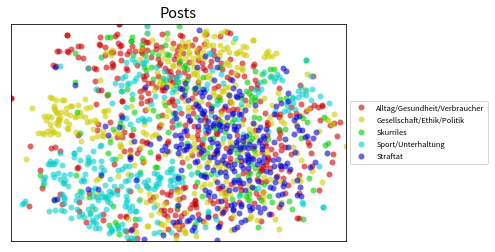

In [12]:
# basic non-interactive plot
categories = sorted(set(post_categories.values()))
basic_viz(ids, post_categories, x, y, dict(zip(categories, categories)), "Posts")

In [13]:
# interactive plots
fig_cats = create_fig_cats(ids, post_categories, x, y, textdict, "Posts")
py.iplot(fig_cats)

### Relabel comments with emotions

In [14]:
post_ids = sorted(posts.keys())
print("getting comment vectors")
comment_vectors = [transform_word2vec_featmat(comments_pp[p], sorted(comments_pp[p]), word_vectors, avg='simple avg') for p in post_ids]
print("getting comment labels")
y = []
for p in post_ids:
    y.extend([emo_main_label[p][c] for c in sorted(emo_main_label[p])])
y = np.array(y)
print("training clf")
clf = LinearSVC(class_weight='balanced')
clf.fit(np.vstack(comment_vectors), y)
print(np.mean(y==clf.predict(np.vstack(comment_vectors))))
print("generating new labels")
emo_main_label_pred = deepcopy(emo_main_label)
for i, p in enumerate(post_ids):
    y_pred_test = clf.predict(comment_vectors[i])   
    for j, c in enumerate(sorted(emo_main_label[p])):
        emo_main_label_pred[p][c] = y_pred_test[j]
del comment_vectors

getting comment vectors
getting comment labels
training clf
0.7044133782690046
generating new labels


In [15]:
# visualize
pid = post_ids[5]  # change number here to analyze the comments of a different post
print(posts[pid])
print(post_categories[pid])
ids = np.random.permutation(list(comments_pp[pid]))[:3000]
textdict = {did: "<br>".join([" ".join(comments[pid][did].split()[i:min(i+5, len(comments[pid][did].split()))]) for i in range(0, len(comments[pid][did].split()), 5)]) for did in ids}
# compute similarities and embedding (choose from sim="simple avg", "simple max", "greedy")
S = compute_w2v_K(ids, comments_pp[pid], word_vectors, sim="simple avg")
S -= S.min()
S /= S.max()
D = 1.-S
S = dist2kernel(D)
x, y = proj2d(S, use_tsne=True, verbose=True)

Mit verschränkten Armen sitzt Dimitri K. im Gerichtssaal. Was er von der Polizei hält  trägt er in seinem Gesicht provokant als Tattoo zur Schau: „Fuck Cops“. regional hamburg g gipfel der hass steht diesem g chaoten ins gesicht geschrieben
Straftat
performing tSNE: 419 datapoints
Iteration 25: error is 4.20140
Iteration 50: error is 3.95597
Iteration 75: error is 3.75827
Iteration 100: error is 4.10746
Iteration 125: error is 2.06755
Iteration 150: error is 1.37085
Iteration 175: error is 1.23483
Iteration 200: error is 1.18848
Iteration 225: error is 1.13726
Iteration 250: error is 1.11762
Iteration 275: error is 1.10002
Iteration 300: error is 1.08513
Iteration 325: error is 1.07519
Iteration 350: error is 1.06814
Iteration 375: error is 1.06150
Iteration 400: error is 1.06028
Iteration 425: error is 1.05973
Iteration 450: error is 1.05927


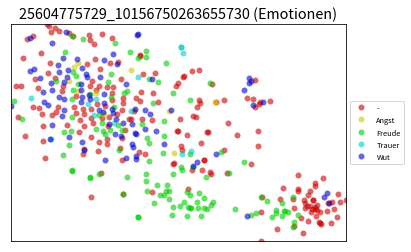

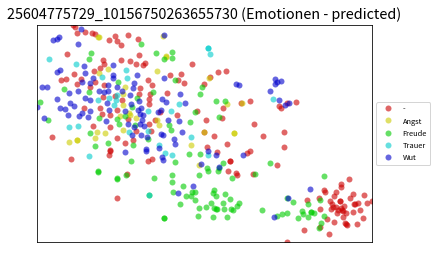

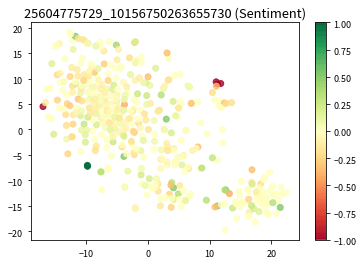

In [16]:
# basic non-interactive plot with emotions and sentiment coloring
basic_viz(ids, emo_main_label[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (Emotionen)")
basic_viz(ids, emo_main_label_pred[pid], x, y, dict(zip(emotions_list, emotions_list)), pid + " (Emotionen - predicted)")
plt.figure()
plt.scatter(x, y, c=[sent_scores[pid][i] for i in ids], alpha=0.8, cmap="RdYlGn")
plt.colorbar()
plt.title(pid + " (Sentiment)");

In [17]:
# interactive plots
fig_emo = create_fig_cats(ids, emo_main_label[pid], x, y, textdict, pid + " (Emotionen)")
fig_emo_pred = create_fig_cats(ids, emo_main_label_pred[pid], x, y, textdict, pid + " (Emotionen - predicted)")
fig_sent = create_fig_scores(ids, sent_scores[pid], x, y, textdict, pid + " (Sentiment)")

py.iplot(fig_emo)
py.iplot(fig_emo_pred)
py.iplot(fig_sent)

### Compute basic stats

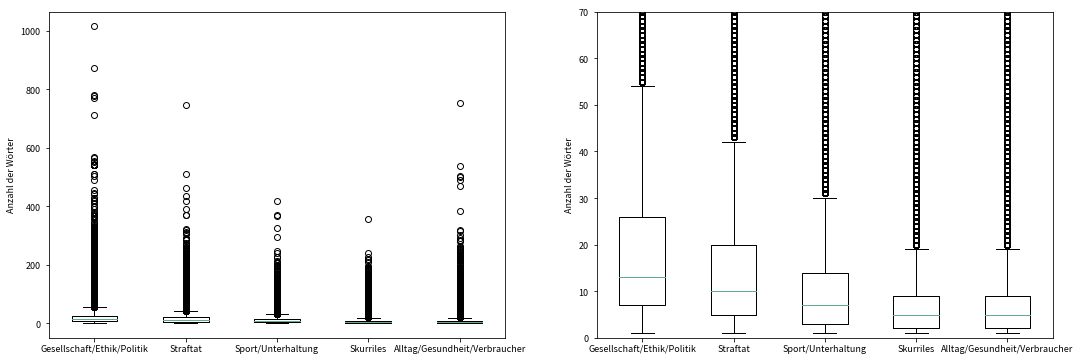

In [18]:
# number of words in comments based on post category
n_words = []
categories = ['Gesellschaft/Ethik/Politik', 'Straftat', 'Sport/Unterhaltung', 'Skurriles', 'Alltag/Gesundheit/Verbraucher']
for post_cat in categories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if post_categories[pid] == post_cat])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=categories)
plt.ylabel("Anzahl der Wörter")
plt.subplot(122)
plt.boxplot(n_words, labels=categories)
plt.ylabel("Anzahl der Wörter")
plt.ylim([0,70]);
plt.savefig("nwords_categories.png", dpi=300, bbox_inches="tight")

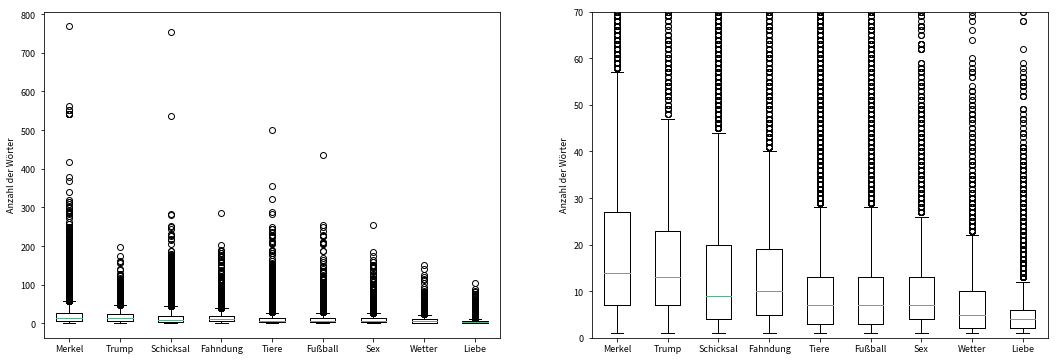

In [19]:
# number of words in comments based on post subcategory
n_words = []
subcategories = ['Merkel', 'Trump', 'Schicksal', 'Fahndung', 'Tiere', 'Fußball', 'Sex', 'Wetter', 'Liebe']
for post_cat in subcategories:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if pid in post_subcategories and post_cat in post_subcategories[pid]])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=subcategories)
plt.ylabel("Anzahl der Wörter")
plt.subplot(122)
plt.boxplot(n_words, labels=subcategories)
plt.ylabel("Anzahl der Wörter")
plt.ylim([0,70]);
plt.savefig("nwords_subcategories.png", dpi=300, bbox_inches="tight")

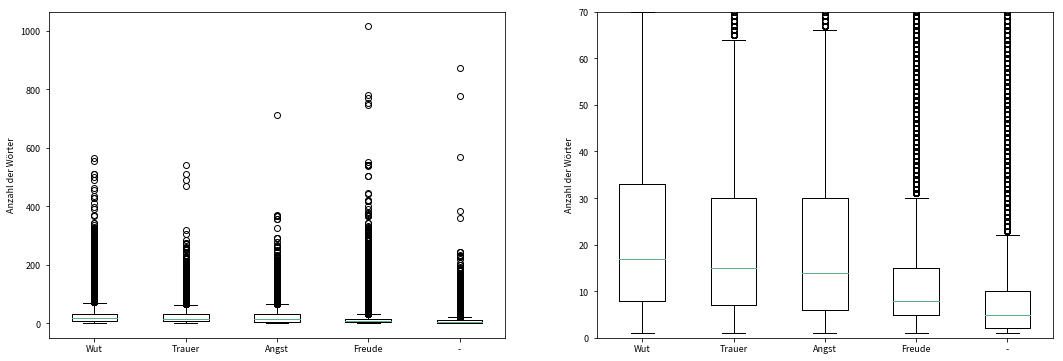

In [20]:
# number of words in comments based on comment emotion
n_words = []
for emo in ["Wut", "Trauer", "Angst", "Freude", "-"]:
    n_words.append([number_of_words[pid][i] for pid in number_of_words for i in number_of_words[pid] if emo_main_label[pid][i] == emo])
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.boxplot(n_words, labels=["Wut", "Trauer", "Angst", "Freude", "-"])
plt.ylabel("Anzahl der Wörter")
plt.subplot(122)
plt.boxplot(n_words, labels=["Wut", "Trauer", "Angst", "Freude", "-"])
plt.ylabel("Anzahl der Wörter")
plt.ylim([0,70]);
plt.savefig("nwords_emotions.png", dpi=300, bbox_inches="tight")

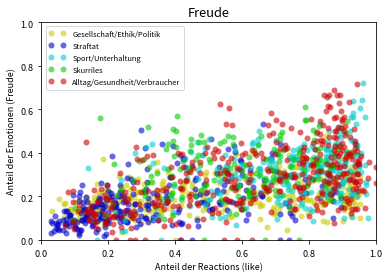

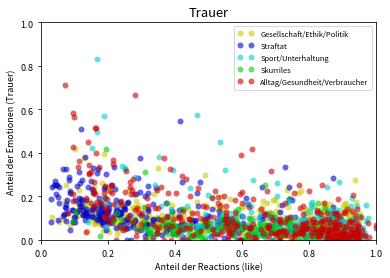

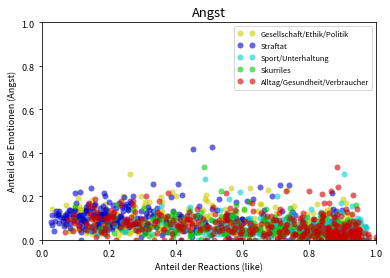

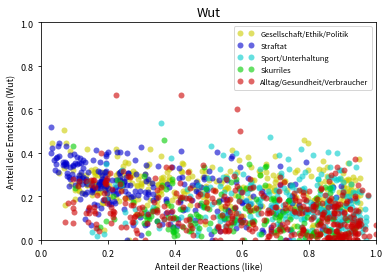

In [33]:
# scatter plots to compare fraction of reactions and emotions and see if they match
reaction = "like"
colorlist = get_colors(len(categories))
colordict = {cat: (colorlist[i][0], colorlist[i][1], colorlist[i][2]) for i, cat in enumerate(sorted(categories))}
for emo in ["Freude", "Trauer", "Angst", "Wut"]:
    plt.figure()
    for post_cat in categories:
        reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
        emos = []
        for pid in post_categories:
            if post_categories[pid] == post_cat:
                r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
                reactions["like"].append(post_likes[pid]/r_total)
                reactions["love"].append(post_love[pid]/r_total)
                reactions["sad"].append(post_sad[pid]/r_total)
                reactions["haha"].append(post_haha[pid]/r_total)
                reactions["angry"].append(post_angry[pid]/r_total)
                reactions["wow"].append(post_wow[pid]/r_total)
                r_total = len(emo_main_label_pred[pid])
                emos.append(sum([1 for i in emo_main_label_pred[pid] if emo_main_label_pred[pid][i] == emo])/r_total)
        plt.plot(reactions[reaction], emos, 'o', label=post_cat, color=colordict[post_cat], alpha=0.6, markeredgewidth=0)
    plt.xlabel("Anteil der Reactions (%s)" % reaction)
    plt.ylabel("Anteil der Emotionen (%s)" % emo)
    plt.title(emo)
    plt.xlim([0,1]);
    plt.ylim([0,1]);
    plt.legend(loc=0)

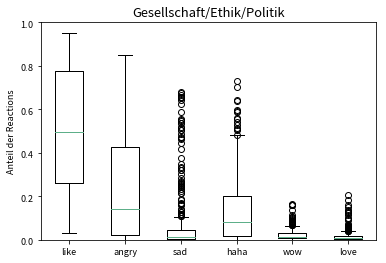

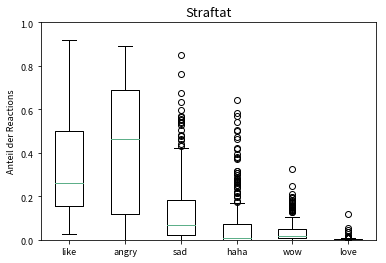

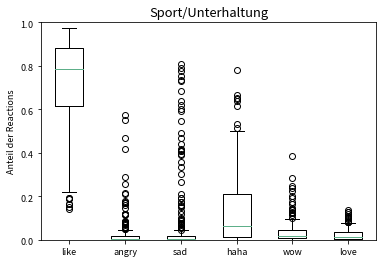

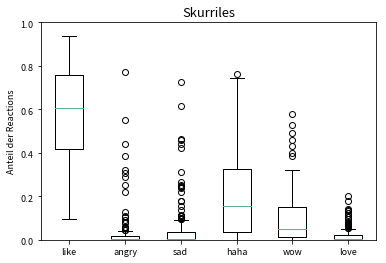

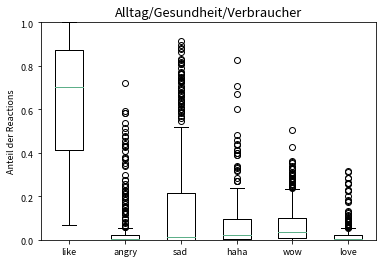

In [38]:
# reactions based on post category
for post_cat in categories:
    reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions["like"].append(post_likes[pid]/r_total)
            reactions["love"].append(post_love[pid]/r_total)
            reactions["sad"].append(post_sad[pid]/r_total)
            reactions["haha"].append(post_haha[pid]/r_total)
            reactions["angry"].append(post_angry[pid]/r_total)
            reactions["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions = [reactions[r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions, labels=r_labels)
    plt.ylabel("Anteil der Reactions")
    plt.title(post_cat)
    plt.ylim([0,1]);

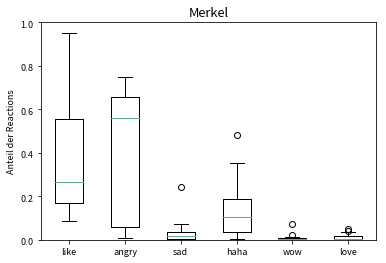

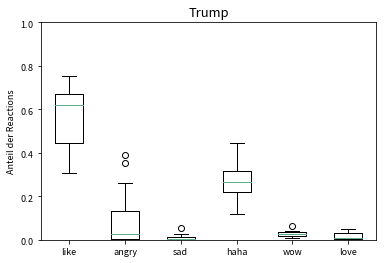

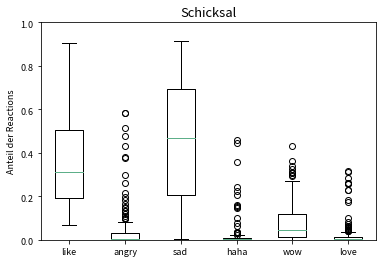

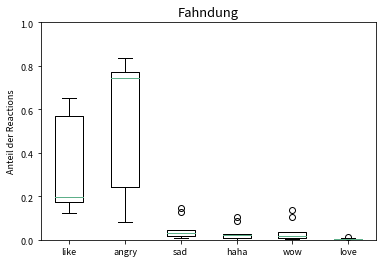

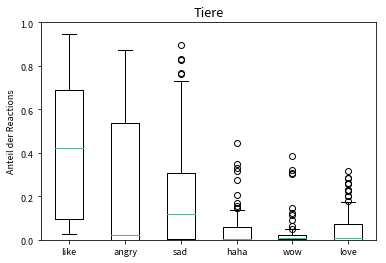

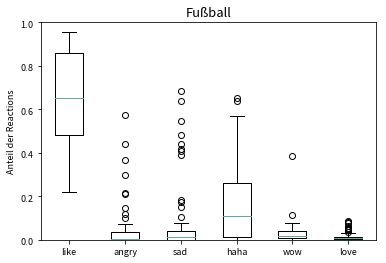

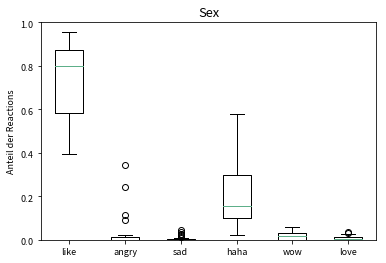

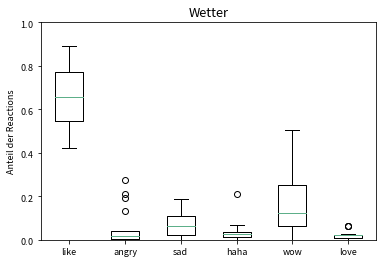

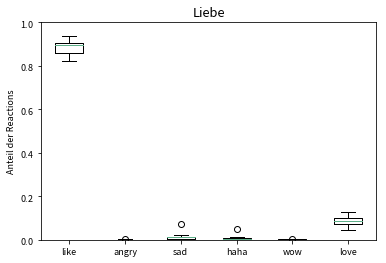

In [39]:
# reactions based on post subcategory
for post_cat in subcategories:
    reactions = {"like": [], "love": [], "sad": [], "haha": [], "angry": [], "wow": []}
    for pid in post_subcategories:
        if post_cat in post_subcategories[pid]:
            r_total = post_likes[pid] + post_love[pid] + post_sad[pid] + post_haha[pid] + post_angry[pid] + post_wow[pid]
            reactions["like"].append(post_likes[pid]/r_total)
            reactions["love"].append(post_love[pid]/r_total)
            reactions["sad"].append(post_sad[pid]/r_total)
            reactions["haha"].append(post_haha[pid]/r_total)
            reactions["angry"].append(post_angry[pid]/r_total)
            reactions["wow"].append(post_wow[pid]/r_total)
    r_labels = ["like", "angry", "sad", "haha", "wow", "love"]
    reactions = [reactions[r] for r in r_labels]
    plt.figure()
    plt.boxplot(reactions, labels=r_labels)
    plt.ylabel("Anteil der Reactions")
    plt.title(post_cat)
    plt.ylim([0,1]);

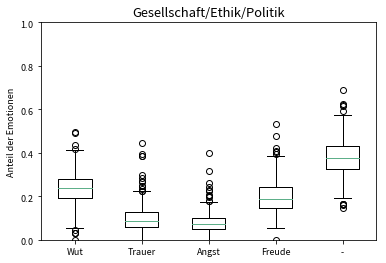

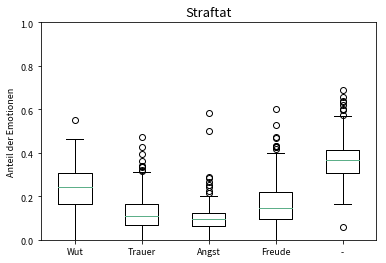

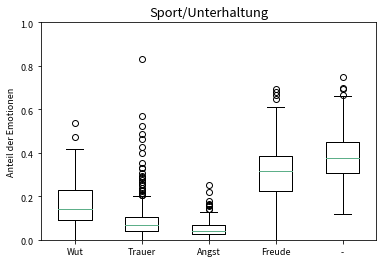

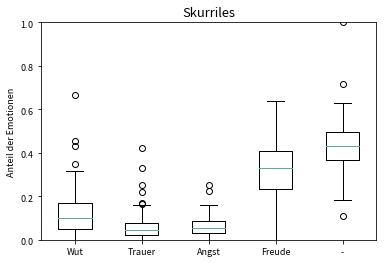

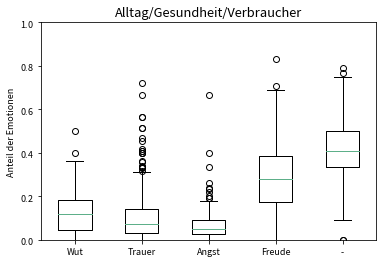

In [40]:
# emotions based on post category
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
for post_cat in categories:
    reactions = {e: [] for e in emotions}
    for pid in post_categories:
        if post_categories[pid] == post_cat:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions = [reactions[r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions, labels=emotions)
    plt.ylabel("Anteil der Emotionen")
    plt.title(post_cat)
    plt.ylim([0,1]);

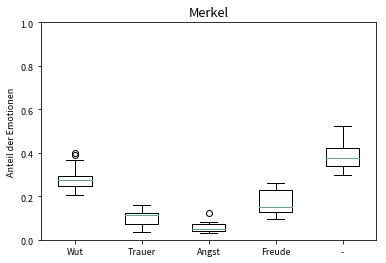

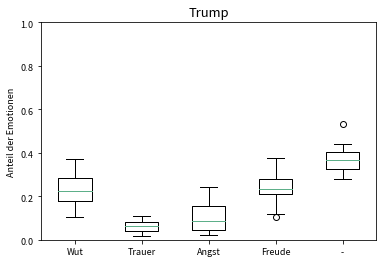

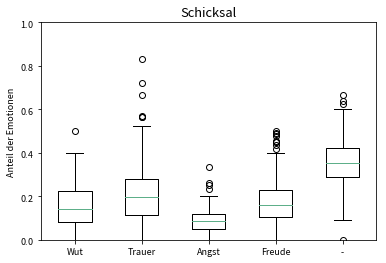

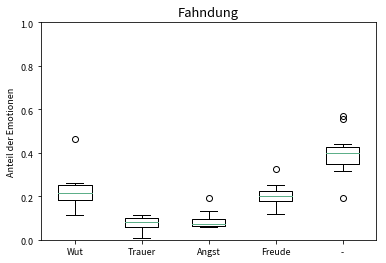

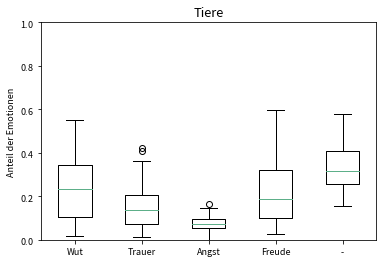

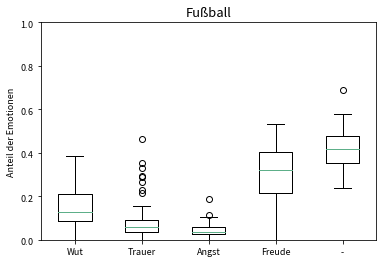

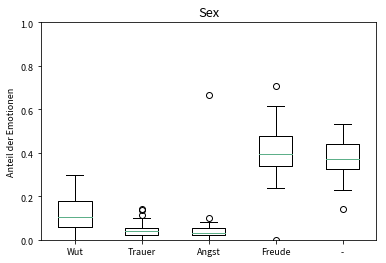

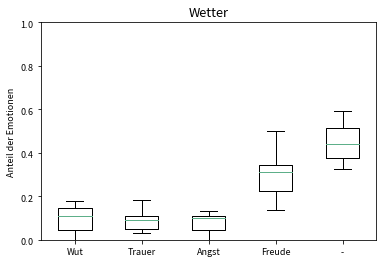

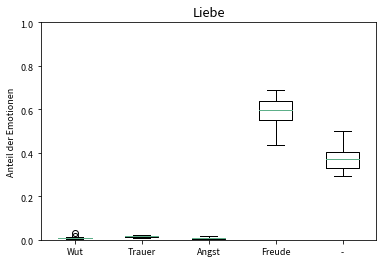

In [41]:
# emotions based on post category
emotions = ["Wut", "Trauer", "Angst", "Freude", "-"]
for post_cat in subcategories:
    reactions = {e: [] for e in emotions}
    for pid in post_subcategories:
        if post_cat in post_subcategories[pid]:
            r_total = len(emo_main_label[pid])
            for emo in emotions:
                reactions[emo].append(sum([1 for i in emo_main_label[pid] if emo_main_label[pid][i] == emo])/r_total)
    reactions = [reactions[r] for r in emotions]
    plt.figure()
    plt.boxplot(reactions, labels=emotions)
    plt.ylabel("Anteil der Emotionen")
    plt.title(post_cat)
    plt.ylim([0,1]);

## Save collected Post stats in CSV file

In [24]:
# (some of the) original fields of the post file with additional categories
cs_columns = ["post_id", "post_text", "category", "subcategory", "react_likes", "react_love", "react_haha", "react_sad", "react_wow",
              "react_angry", "number of comments", "positive sent", "negative sent", "neutral sent", "Wut", "Angst",
              "Trauer", "Freude", "neutral", "avg words in comments", "median words in comments"]
index = sorted(posts.keys())
collected_stats = {}
collected_stats["post_id"] = index
collected_stats["post_text"] = [posts[i] for i in index]
collected_stats["category"] = [post_categories[i] for i in index]
collected_stats["subcategory"] = [post_subcategories[i] if i in post_subcategories else "" for i in index]
collected_stats["react_likes"] = [post_likes[i] for i in index]
collected_stats["react_love"] = [post_love[i] for i in index]
collected_stats["react_haha"] = [post_haha[i] for i in index]
collected_stats["react_sad"] = [post_sad[i] for i in index]
collected_stats["react_wow"] = [post_wow[i] for i in index]
collected_stats["react_angry"] = [post_angry[i] for i in index]
collected_stats["number of comments"] = [len(comments[i]) for i in index]
collected_stats["avg words in comments"] = [np.mean(list(number_of_words[i].values())) for i in index]
collected_stats["median words in comments"] = [np.median(list(number_of_words[i].values())) for i in index]
collected_stats["positive sent"] = [100*len([1 for s in sent_scores[i].values() if s > 0])/len(sent_scores[i]) for i in index]
collected_stats["negative sent"] = [100*len([1 for s in sent_scores[i].values() if s < 0])/len(sent_scores[i]) for i in index]
collected_stats["neutral sent"] = [100*len([1 for s in sent_scores[i].values() if s == 0])/len(sent_scores[i]) for i in index]
collected_stats["Wut"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Wut"])/len(emo_main_label[i]) for i in index]
collected_stats["Angst"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Angst"])/len(emo_main_label[i]) for i in index]
collected_stats["Trauer"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Trauer"])/len(emo_main_label[i]) for i in index]
collected_stats["Freude"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "Freude"])/len(emo_main_label[i]) for i in index]
collected_stats["neutral"] = [100*len([1 for emo in emo_main_label[i].values() if emo == "-"])/len(emo_main_label[i]) for i in index]
df = pd.DataFrame(collected_stats, columns=cs_columns)
df.to_csv("collected_stats.csv", index=False)